<a href="https://colab.research.google.com/github/KTaskn/StudiesForML/blob/master/FaceFeature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cnn_finetune

     |████████████████████████████████| 61kB 6.4MB/s 
  Created wheel for cnn-finetune: filename=cnn_finetune-0.6.0-cp36-none-any.whl size=11432 sha256=1b9de9248e30d4bb11de35afde551889a2d76067c5e1e159f37a6f1b89836099
  Stored in directory: /root/.cache/pip/wheels/12/4f/29/32978e72b606c5f51b6bd10117814deb46c6b63230eef49381
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=3328d675afe3ce2d3a8645b2e39f8d2b6c1dd87fdd08a13b72642304fd0c7a4b
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built cnn-finetune pretrainedmodels


In [2]:
!wget https://zenodo.org/record/3451524/files/jaffedbase.zip
!unzip jaffedbase.zip

--2020-03-07 08:15:52--  https://zenodo.org/record/3451524/files/jaffedbase.zip
Resolving zenodo.org (zenodo.org)... 188.184.95.95
Connecting to zenodo.org (zenodo.org)|188.184.95.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12242135 (12M) [application/octet-stream]
Saving to: ‘jaffedbase.zip’

jaffedbase.zip      100%[===================>]  11.67M  51.3MB/s    in 0.2s    

2020-03-07 08:15:53 (51.3 MB/s) - ‘jaffedbase.zip’ saved [12242135/12242135]

Archive:  jaffedbase.zip
   creating: jaffedbase/
  inflating: jaffedbase/MK.AN3.127.tiff  
   creating: __MACOSX/
   creating: __MACOSX/jaffedbase/
  inflating: __MACOSX/jaffedbase/._MK.AN3.127.tiff  
  inflating: jaffedbase/MK.NE1.113.tiff  
  inflating: __MACOSX/jaffedbase/._MK.NE1.113.tiff  
  inflating: jaffedbase/YM.AN3.63.tiff  
  inflating: __MACOSX/jaffedbase/._YM.AN3.63.tiff  
  inflating: jaffedbase/MK.SA1.119.tiff  
  inflating: __MACOSX/jaffedbase/._MK.SA1.119.tiff  
  inflating: jaffedbase/KA.A

In [0]:
import torch.nn as nn
from cnn_finetune import make_model

class Net(nn.Module):
    def __init__(self, C):
      super(Net, self).__init__()
      self.nn = make_model('mobilenet_v2', num_classes=C, pretrained=True, input_size=(256, 256))

    def forward(self, X):
      return self.nn(X)

In [0]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
      super(TripletLoss, self).__init__()
      self.margin = margin
    
    def forward(self, x0, x1, x2):
      # x0に対して、x1は同じ人物or同じ表情
      # x0に対して、x2は異なる人物or異なる表情
      # x0とx1のユークリッド距離を計算
      d1 = torch.sqrt(torch.sum(torch.pow(x0 - x1, 2), 1))
      # x0とx2のユークリッド距離を計算
      d2 = torch.sqrt(torch.sum(torch.pow(x0 - x2, 2), 1))
      # d1 - d2 < 0 .. つまり、d1 < d2 .. x0とx1（同じもの）は近い、x0とx2（異なるもの）は遠い なら損失は0 -> 現状維持
      # d1 - d2 > 0 .. つまり、d1 > d2 .. x0とx1は遠い、x0とx2は近い なら損失が大きくなる -> 最適化される
      loss = torch.clamp(d1 - d2 + self.margin, min=0.0)
      return torch.sum(loss) / x0.size()[0]

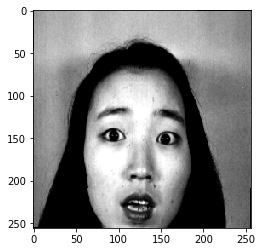

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import torch
from torchvision import transforms
import numpy as np
import pandas as pd

class FaceDataset(torch.utils.data.Dataset):
    def __init__(self, files, transform):
      self.transform = transform
      self.df = pd.DataFrame({
          # ファイル名から人と表情の識別子を取り出す
          # 人の識別子 例） KM.HA1.4.tiff -> KM
          'name': list(map(lambda x: x.split('/')[-1].split('.')[0], files)),
          # 表情の識別子 例） KM.HA1.4.tiff -> HA
          'face': list(map(lambda x: x.split('/')[-1].split('.')[1][:-1], files)),
          # ファイル名
          'path': files
      })      
      #　同じ人の同じ表情について重複があるので、ユニークにする。
      self.df = self.df.groupby(['face', 'name']).head(1)

    def __len__(self):
      # データの長さ
      return len(self.df.index)

    def __getitem__(self, idx):
      # idxの位置のデータ行を取り出す
      row = self.df.iloc[idx]
      # ファイルパス
      path = row['path']
      # ファイルパスから画像データを読み取り
      img = self.open_image(path)
      
      # 今回は明示的に人物と表情の距離を分ける
      # 50:50の確率で人物と表情の組み合わせとで学習を分ける
      if np.random.random() < 0.5:
        # 人物
        # 人物名を取り出す
        name = row['name']
        # 同じ人物の別表情画像
        path_same = self.df.pipe(lambda df: df[df['name'] == name]).sample(1)['path'].tolist()[0]
        img_same = self.open_image(path_same)
        # 別人物の画像
        path_other = self.df.pipe(lambda df: df[df['name'] != name]).sample(1)['path'].tolist()[0]
        img_other = self.open_image(path_other)
      else:
        # 表情
        #　表情名を取り出す
        face = row['face']
        # 同じ表情の別人物画像
        path_same = self.df.pipe(lambda df: df[df['face'] == face]).sample(1)['path'].tolist()[0]
        img_same = self.open_image(path_same)
        # 異なる表情の画像
        path_other = self.df.pipe(lambda df: df[df['face'] != face]).sample(1)['path'].tolist()[0]
        img_other = self.open_image(path_other)

      # 個々の画像についてtransformで画像を変形して結果を返す
      return self.transform(img), self.transform(img_same), self.transform(img_other), path

    def open_image(self, path):
      return Image.open(path).convert('RGB')

# 画像を変形する処理
transform = transforms.Compose([
    # ランダムにサイズ変更
    transforms.RandomResizedCrop((256, 256), scale=(0.75, 1.0)),
    # ランダムに色合いを変更
    transforms.ColorJitter(brightness=0.3, contrast=0.5, saturation=0.5, hue=0),
    # ランダムに水平反転
    transforms.RandomHorizontalFlip(0.5),
    # ランダムにアフィン・シーア変換
    transforms.RandomAffine(0.5, shear=0.5),
    # pytorchテンソルに変換
    transforms.ToTensor()
])


# wget https://zenodo.org/record/3451524/files/jaffedbase.zip
# unzip jaffedbase.zip
# データセットの画像ファイルを読み込み
files = glob('jaffedbase/*.tiff')

dataset = FaceDataset(files, transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

def plot(X):
  plt.imshow(np.transpose(X, (1, 2, 0)))
  plt.show()

for X0, _, _, path in dataloader:
  plot(X0[0].numpy())
  break

In [6]:
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

# Cは任意の数、今回は人物・表情のパターン分とする
C = dataset.df['face'].nunique() * dataset.df['name'].nunique()

# cpu/cudaを指定
device = torch.device('cuda')
# モデルを生成
model = Net(C)
model = model.to(device)
# 損失関数
criterion = TripletLoss()
# 最適化関数
optimizer = optim.Adam(model.parameters(), lr=0.0001)

EPOCH = 50
for idx in range(EPOCH):
  model.train()
  all_loss = 0.0
  for X0, X1, X2, path in dataloader:
    # テンソルの型をdeviceに合わせて変換
    X0 = X0.to(device)
    X1 = X1.to(device)
    X2 = X2.to(device)
    
    # 損失計算
    loss = criterion(model(X0), model(X1), model(X2))

    # 勾配計算・学習
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    all_loss += loss.item()
  print(all_loss)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth



4.2532917857170105
4.785244047641754
4.256834387779236
3.9933589100837708
3.0249484181404114
3.366792321205139
3.6276272535324097
2.463338753208518
3.817072957754135
3.0505412220954895
2.494810163974762
2.4732735753059387
2.9442601799964905
2.4068421721458435
2.060907557606697
2.7410658597946167
3.2674006521701813
2.6637584567070007
2.5643506944179535
3.1428287029266357
1.7018290013074875
2.252234660089016
2.8722346425056458
3.403661370277405
2.4938890039920807
1.2588386535644531
2.8902968168258667
3.771792769432068
2.2552530020475388
2.8826341032981873
1.4522190168499947
2.4776357114315033
3.124268651008606
3.253781735897064
3.0531405806541443
2.408490002155304
2.969449520111084
2.493774801492691
2.9814935326576233
2.860172614455223
2.7286829352378845
2.3277257084846497
2.994682490825653
2.2400562167167664
2.9575418829917908
1.5893487632274628
3.2616246044635773
3.347478151321411
3.0912622213363647
2.708696573972702


In [7]:
!pip install ngt

     |████████████████████████████████| 1.9MB 8.2MB/s 
     |████████████████████████████████| 153kB 26.9MB/s 


In [0]:
def norm(ary):
  # 非負ベクトルに変換する
  func = lambda x: (x - x.min()) / x.max()
  if len(ary.shape) > 1:
    return np.array([func(row) for row in np.array(ary)])
  else:
    return func(np.array(ary))

def l2norm(ary):
  # ベクトルをベクトルのL2ノルム(ユークリッド距離)で割ることで、ユークリッド距離が1のベクトルに変換する
  def underto0(ary):
    # 負は0に置き換える
    ary[ary < 0] = 0
    return ary

  func = lambda x: x / np.linalg.norm(x, ord=2)
  if len(ary.shape) > 1:
    return np.array([func(underto0(row)) for row in np.array(ary)])
  else:
    return func(underto0(np.array(ary)))


In [0]:
import ngtpy

# 評価用の画像は変形を行わない
transform = transforms.Compose([
  # 画像を任意のサイズにサイズ変更
  transforms.Resize((256, 256)),
  # torchのテンソル型に変換
  transforms.ToTensor()
])
# 画像変形を行わない評価用のデータセット
eval_dataset = FaceDataset(files, transform)
# バッチサイズは1にして画像を１つずつ取り出す
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=1, shuffle=False)

vectors = []
files = []
for X, _, _, path in eval_dataloader:
  X = X.to(device)
  # mobilenet_v2のGAP層のベクトルを取り出す。その際に、axis=2方向にmedianを行い値をつぶす。
  # =>不要かも？
  a_vector = np.median(np.median(model.nn._features(X).cpu().tolist(), axis=2), axis=2)[0].tolist()
  vectors.append(a_vector)
  files.append(path[0])

# L2ノルムが1の非負のベクトルに変換する
features = l2norm(norm(np.array(vectors)))

# 近傍探索ライブラリにベクトルを保管する
dim = features.shape[1]
ngtpy.create("images", dim)
index = ngtpy.Index("images")
index.batch_insert(features)
index.save()


In [10]:
from PIL import Image
import random

class Feature:
  # 特徴量を作り出すクラス
  def __init__(self, features, df_dataset):
    # 非負かつL2ノルム=1に変換済みの特徴ベクトル
    self.features = features
    # ファイルパスと、人物・表情ラベルがついたpandasデータフレーム
    # => データローダのを使う
    self.df_dataset = df_dataset
    self.files = df_dataset['path']

  
  def get_face(self, name, face, num=0):
    if face in self.df_dataset['face'].unique():
      if name in self.df_dataset['name'].unique():
        mask = (self.df_dataset['name'] == name) & (self.df_dataset['face'] == face)
        return self.features[mask][num], self.files[mask].index.tolist()[num]
      else:
        raise Exception('存在しない名前です：', face)
    else:
      raise Exception('存在しない表情です：', face)


  def get_feature_face(self, face):
    # 指定した表情の特徴ベクトルを取り出す。
    if face in self.df_dataset['face'].unique():
      # 指定された表情の特徴ベクトルだけをフィルタリングで取り出す。
      # 特徴ベクトルの中央値を非負L2ノルム1変換をかけたベクトルを、その表情の特徴ベクトルとする
      return l2norm(np.median(self.features[self.df_dataset['face'] == face], axis=0))
    else:
      raise Exception('存在しない表情です：', face)

  def get_feature_name(self, name):
    # 指定した人物の特徴ベクトルを取り出す。
    if name in self.df_dataset['name'].unique():
      # 指定された人物の特徴ベクトルだけをフィルタリングで取り出す。
      # 特徴ベクトルの中央値を非負L2ノルム1変換をかけたベクトルを、その人物の特徴ベクトルとする
      return l2norm(np.median(self.features[self.df_dataset['name'] == name], axis=0))
    else:
      raise Exception('存在しない名前です：', name)

  def plot(self, l_idx):
    # 検索結果を表示するためのメソッド
    def get_concat_h(im1, im2):
      # 画像を横つなぎにする
      dst = Image.new('RGB', (im1.width + im2.width, im1.height))
      dst.paste(im1, (0, 0))
      dst.paste(im2, (im1.width, 0))
      return dst

    idx = l_idx[0]
    img = Image.open(self.files[idx])
    for idx in l_idx[1:]:
      img = get_concat_h(img, Image.open(self.files[idx]))
    display(img)

obj_f = Feature(features, eval_dataset.df.reset_index(drop=True))

NAME = ['KL', 'NM', 'KR', 'KA', 'YM', 'MK', 'UY', 'TM', 'NA', 'KM']
FACE = ['HA', 'NE', 'SU', 'AN', 'FE', 'DI', 'SA']

get_name = lambda x: x.split('/')[-1].split('.')[0]
get_face = lambda x: x.split('/')[-1].split('.')[1][:-1]

N = 100
SUCCESS = 0
for num in range(N):
  # ランダムに人物と表情の識別子を取り出す
  name = random.choice(NAME)
  face = random.choice(FACE)

  # 個々の特徴ベクトルを計算する
  feature_name = obj_f.get_feature_name(name)
  feature_face = obj_f.get_feature_face(face)

  # 人物ベクトルと表情ベクトルを足し合わせる
  search_x = l2norm(feature_name + feature_face)

  # 近傍探索を実施する
  # search_xに最も近い特徴ベクトルが取り出される
  result = index.search(search_x, 1)
  for idx, d in result:
    filename = obj_f.files[idx]
    if get_face(filename) == face and get_name(filename) == name:
      SUCCESS += 1
print(SUCCESS / N)

0.82


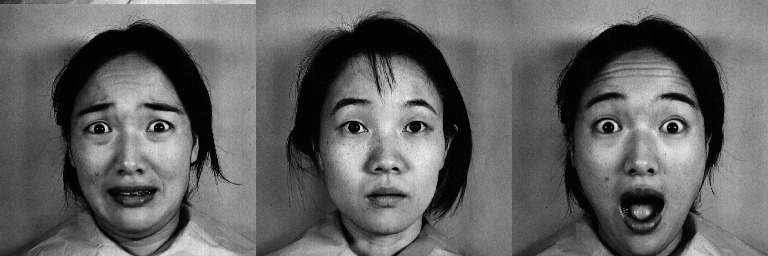

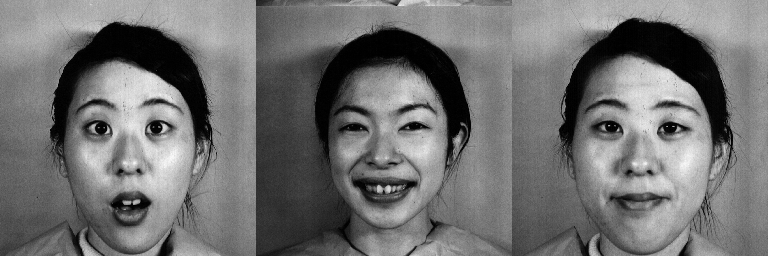

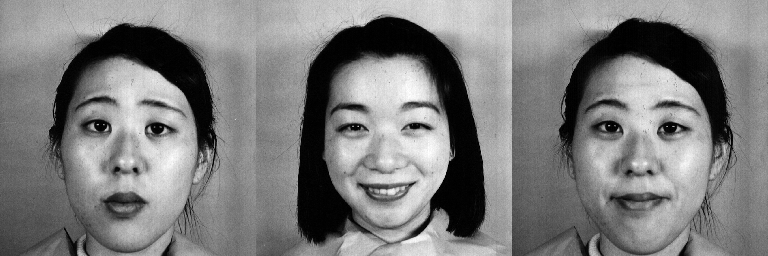

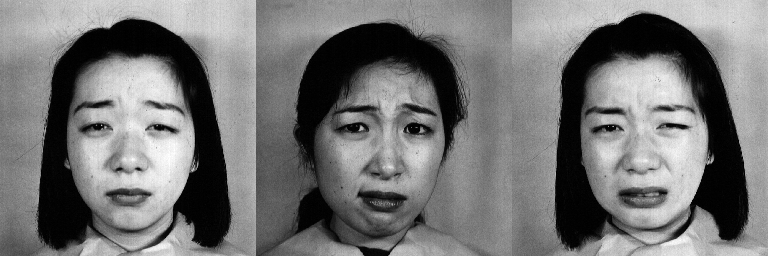

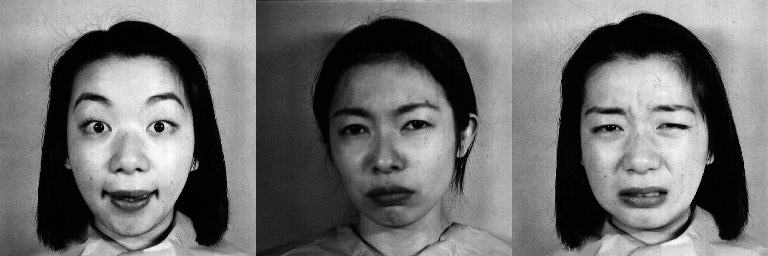

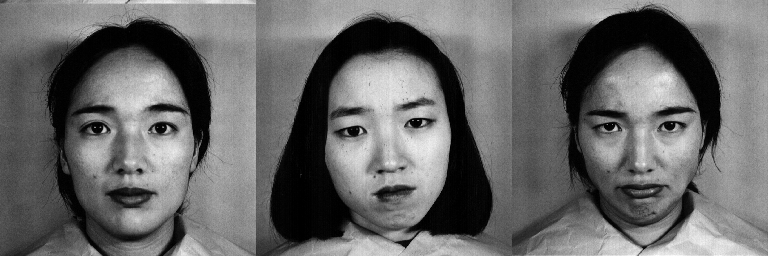

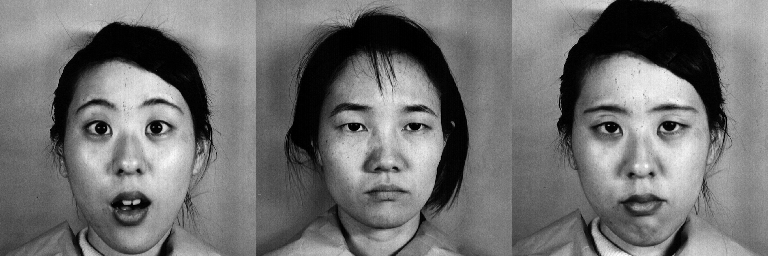

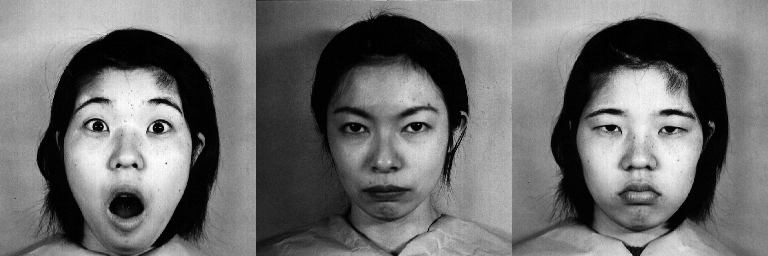

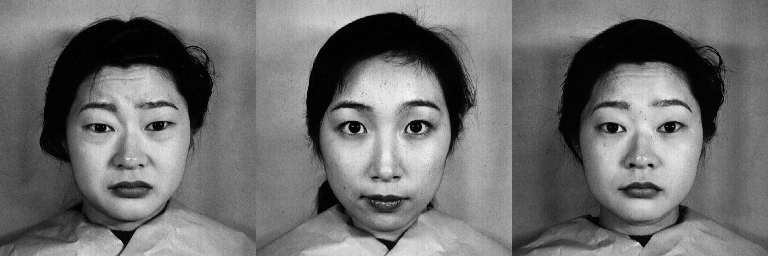

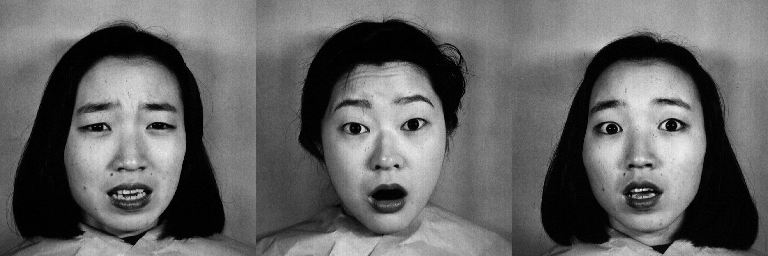

In [11]:
for num in range(10):
  name0 = random.choice(NAME)
  name1 = random.choice(list(set(NAME) - set([name0])))
  face0 = random.choice(FACE)
  face1 = random.choice(list(set(FACE) - set([face0])))

  feature_man_0, idx_0 = obj_f.get_face(name0, face0)
  feature_man_1, idx_1 = obj_f.get_face(name1, face1)
  feature_0 = obj_f.get_feature_name(name0)
  feature_1 = obj_f.get_feature_face(face1)

  l_idx = [idx_0, idx_1]
  search_x = l2norm(feature_0 + feature_1)
  result = index.search(search_x, 5)
  for idx, d in result:
    if idx not in l_idx:
      l_idx.append(idx)
  obj_f.plot(l_idx[:3])